<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v4)
In this notebook I'll experiment with some minor architectural variations.

In [ ]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout 12651a902e4451cadb29e750273d956a7d23f0a0
#!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import unet
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(unet)

HEAD is now at 15e7230 Adding ability to experiment with different conv kernel sizes
Already up to date.


<module 'unet' from '/content/repo/unet.py'>

In [ ]:
!pip install -Uqq ipdb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [ ]:
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Helper functions

In [ ]:
def display_history(history):
  plt.figure(figsize=(11,3))
  plt.subplot(1,2,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")

  plt.subplot(1,2,2)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")
  plt.show()

def show_prediction(display_list, titles):
    plt.figure(figsize=(10, 3))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(model, dataset, num=1, show_probs=True):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = model.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]

        if show_probs:
          # showing full details
          print(f"Class 0 logit range - {tf.reduce_min(batch_pred[..., 0])}, {tf.reduce_max(batch_pred[..., 0])}")
          print(f"Class 1 logit range - {tf.reduce_min(batch_pred[..., 1])}, {tf.reduce_max(batch_pred[..., 1])}")
          #probs = tf.nn.softmax(batch_pred[0], axis=-1)
          probs = batch_pred[0]  # show the raw logits
          class0_prob = probs[:, :, 0]
          class1_prob = probs[:, :, 1]
          show_prediction(
              [image, ground_truth, pred, class0_prob, class1_prob],
              ['LDS Data', 'Ground Truth', 'Predicted', 'Class 0', 'Class 1'])
        else:
          show_prediction([image, ground_truth, pred], ['LDS Data', 'Ground Truth', 'Predicted'])

## Training data
Just fetch the pre-generated training data.

In [ ]:
# If generated data is available then load that to save time:
loaded = np.load('repo/data/experimental-lds-training-data1.npz')
X = loaded['X']
Y = loaded['Y']
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# Make available for training
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

X: 1000 x (105, 105)
Y: 1000 x (105, 105)


# Baseline
Setup our simple model.
And then let's get a sample result for a baseline.

In [ ]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

model = unet.unet_model(input_size, n_filters, n_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=7, h=7
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 675ms/step - accuracy: 0.8928 - ce: 0.9312 - loss: 0.9312
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.9764 - ce: 0.1002 - loss: 0.1002
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9771 - ce: 0.0874 - loss: 0.0874
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9765 - ce: 0.0876 - loss: 0.0876
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9768 - ce: 0.0856 - loss: 0.0856
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9766 - ce: 0.0844 - loss: 0.0844
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9766 - ce: 0.0835 - loss: 0.0835
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9763 - ce: 0.0826 - loss: 0.0826
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy:

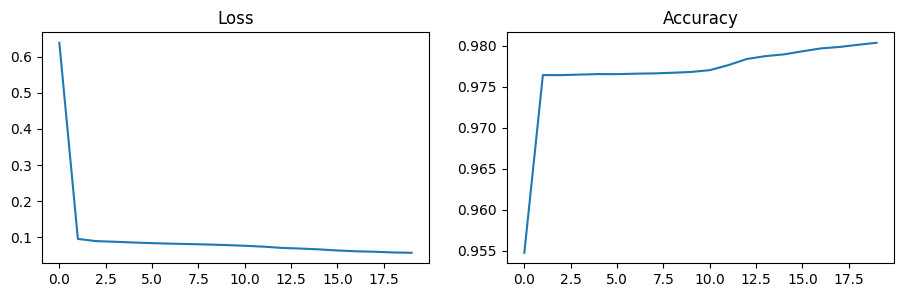

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class 0 logit range - -3.353217840194702, 11.550232887268066
Class 1 logit range - -8.802824974060059, 2.7297935485839844


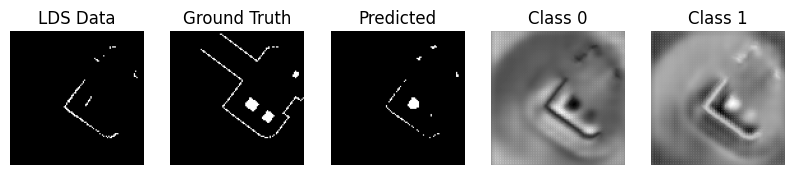

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -5.750606536865234, 11.489163398742676
Class 1 logit range - -9.048285484313965, 3.6793906688690186


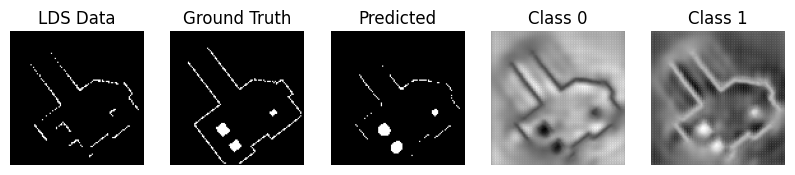

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class 0 logit range - -1.4214345216751099, 16.012399673461914
Class 1 logit range - -12.610658645629883, 1.158756971359253


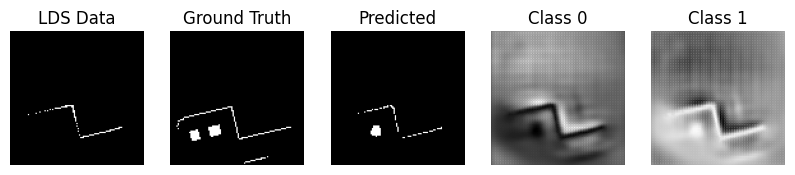

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -1.2806317806243896, 14.04300308227539
Class 1 logit range - -9.665277481079102, 0.9207220673561096


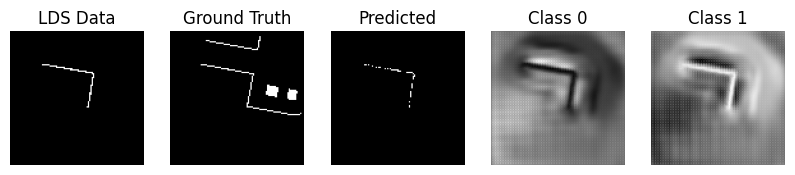

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -1.1809577941894531, 16.52326011657715
Class 1 logit range - -12.37106704711914, 0.7482752203941345


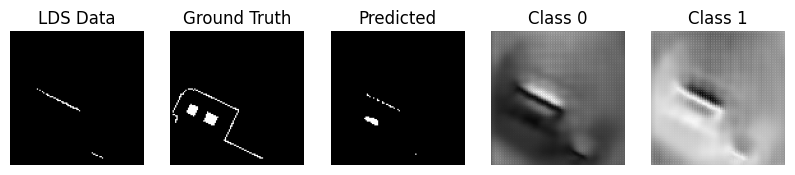

In [ ]:
display_history(model_history)
show_predictions(model, dataset, 5)

## Kernel Size
Let's see what ahppens with a larger kernel size.

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=7, h=7
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 713ms/step - accuracy: 0.9604 - ce: 23.1523 - loss: 23.1523
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9768 - ce: 0.1019 - loss: 0.1019
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.9761 - ce: 0.0913 - loss: 0.0913
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.9764 - ce: 0.0866 - loss: 0.0866
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.9771 - ce: 0.0835 - loss: 0.0835
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.9765 - ce: 0.0837 - loss: 0.0837
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9768 - ce: 0.0818 - loss: 0.0818
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.9767 - ce: 0.0811 - loss: 0.0811
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accur

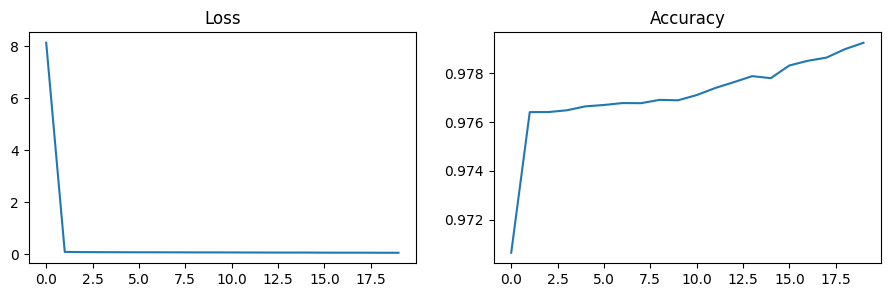

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class 0 logit range - -2.0327394008636475, 22.99213218688965
Class 1 logit range - -17.95277976989746, 3.165205240249634


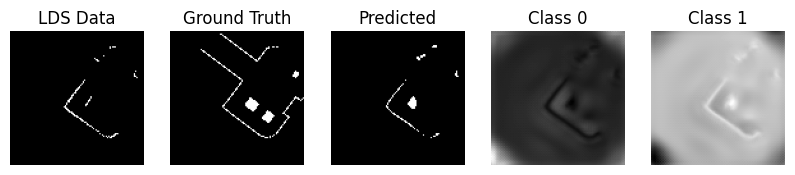

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class 0 logit range - -2.4755146503448486, 39.495418548583984
Class 1 logit range - -31.6082763671875, 3.8812334537506104


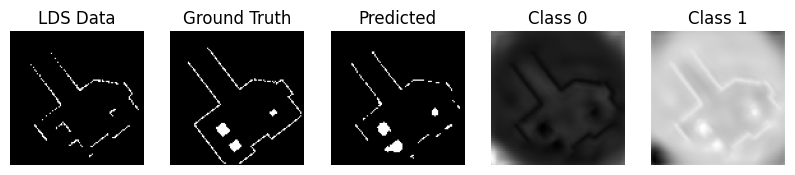

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class 0 logit range - -0.9101123213768005, 13.78393268585205
Class 1 logit range - -10.75709056854248, 1.0705721378326416


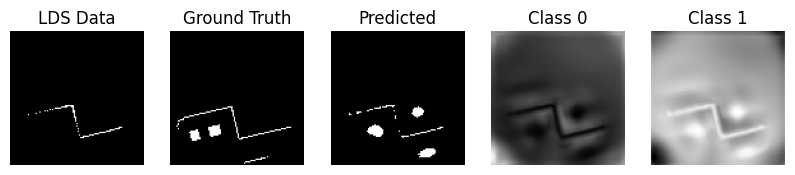

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -0.7810956239700317, 22.607959747314453
Class 1 logit range - -18.178686141967773, 1.0823298692703247


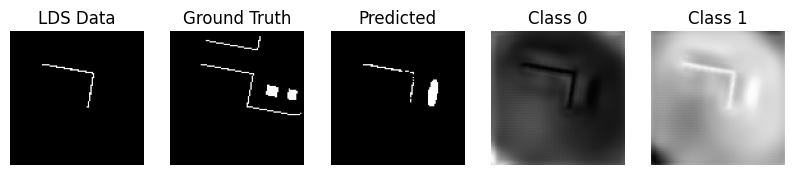

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -0.6198039054870605, 15.334480285644531
Class 1 logit range - -12.010468482971191, 0.8209843039512634


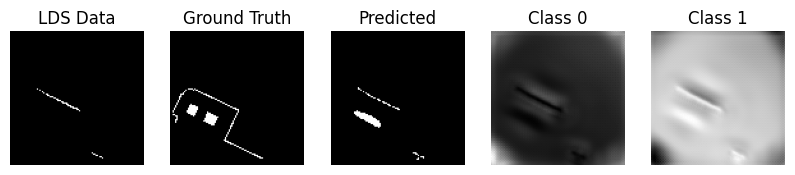

In [ ]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

model = unet.unet_model(input_size, n_filters, n_classes, kernel_size=(5, 5))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 112, 112, 1)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 32)   │            832 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 112, 112, 32)   │         25,632 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 64)     │         51,264 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 64)     │        102,464 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 28, 28, 128)    │        204,928 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 28, 28, 128)    │        409,728 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 14, 14, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 14, 14, 256)    │        819,456 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 14, 14, 256)    │      1,638,656 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 14, 14, 256)    │              0 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 7, 7, 256)      │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 7, 7, 512)      │      3,277,312 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)   

 Total params: 71,974,568 (274.56 MB)

 Trainable params: 23,991,522 (91.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,983,046 (183.04 MB)

## Results
* 3x3 conv kernel (baseline):
  * Total params: 25,917,608 (98.87 MB)
  * Trainable params: 8,639,202 (32.96 MB)
  * Optimizer params: 17,278,406 (65.91 MB)
  * Training speed: 136ms/step (batch size 32, padding done as layer)
  * After 20 epochs: accuracy = 0.9806, cross-entropy loss = 0.0567
* 5x5 conv kernel:
  * Total params: 71,974,568 (274.56 MB)
  * Trainable params: 23,991,522 (91.52 MB)
  * Optimizer params: 47,983,046 (183.04 MB)
  * Training speed: 266ms/step
  * After 20 epochs: accuracy = 0.9792, cross-entropy loss = 0.0634
  * Visually much worse.
  * Noticeably slower.

  Conclusions:
  * For the sake of experimentation efficiency, until I run into a problem of the training data getting too complex and the network getting saturated, this kernel size and most probably this depth too are perfectly sufficient for the task.

## Long training against Baseline
Let's run the baseline architecture for 200 epochs and see what result we get. This will be useful for comparing to later.

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=7, h=7
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.9093 - loss: 0.6381
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9760 - loss: 0.0963
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9768 - loss: 0.0880
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9767 - loss: 0.0868
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9771 - loss: 0.0830
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9767 - loss: 0.0835
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9767 - loss: 0.0827
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9766 - loss: 0.0810
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9769 - loss: 0.0811
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9770

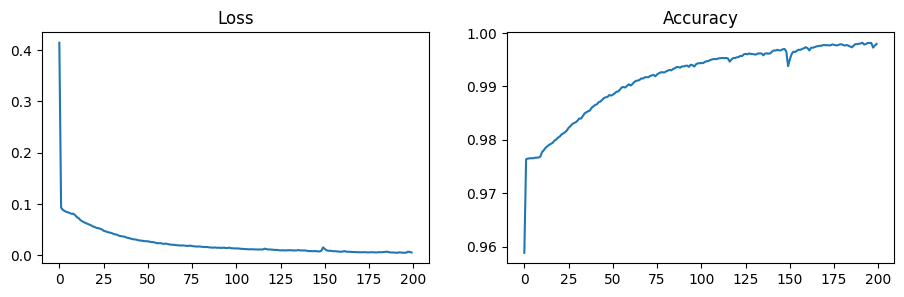

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class 0 logit range - -6.276638507843018, 71.2861557006836
Class 1 logit range - -84.15645599365234, 43.06684875488281


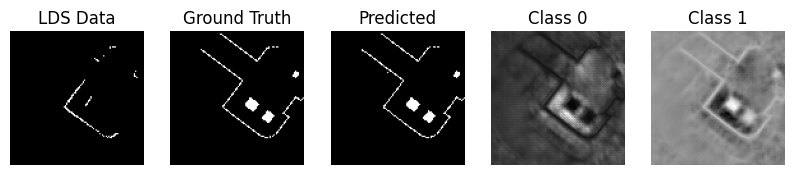

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class 0 logit range - -7.631663799285889, 72.60686492919922
Class 1 logit range - -100.6620864868164, 55.158390045166016


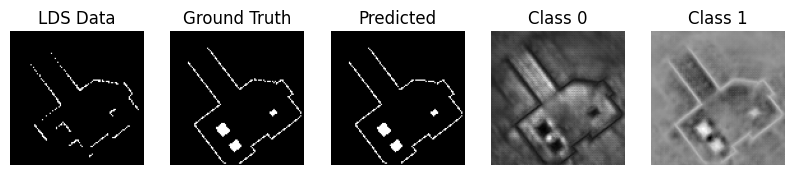

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Class 0 logit range - -3.4997360706329346, 55.7559700012207
Class 1 logit range - -73.49876403808594, 26.580535888671875


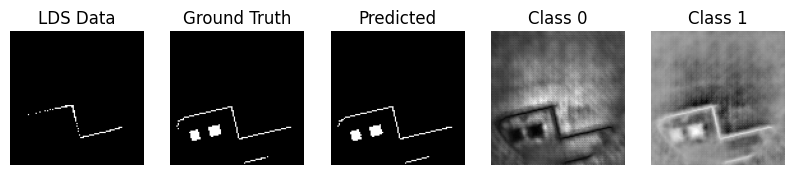

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -2.818577289581299, 51.53985595703125
Class 1 logit range - -69.06954193115234, 21.01592254638672


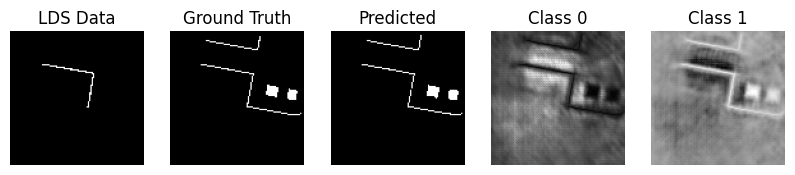

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - -3.1484737396240234, 44.72184371948242
Class 1 logit range - -55.097652435302734, 22.65713882446289


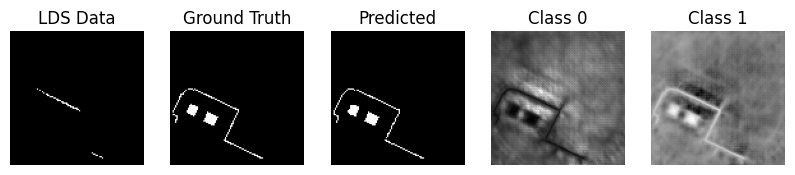

AttributeError: module 'unet' has no attribute 'save'

In [ ]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
model = unet.unet_model(input_size, n_filters=32, n_classes=2)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size=32).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=200)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

In [ ]:
# save model to disk for getting back into this later
model.save('experimental-lds-to-occupancy-model1-200epochs.keras')

# ...or relead
#unet = tf.keras.models.load_model('unet.keras')